In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
plt.rcParams["font.family"] = "serif"

from astropy        import units, constants
from p3droslo.lines import Line
from p3droslo.loss  import Loss
from p3droslo.model import TensorModel, SphericalModel
from p3droslo.utils import print_var, planck

In [135]:
n_elements = 1024

r_in   = (1.0e-1 * units.au).si.value
r_out  = (1.0e+4 * units.au).si.value
r_max  = (1.0e+2 * units.au).si.value


v_in  = (1.0e+0 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

T_in    = (5.0e+3 * units.K).si.value
epsilon = 0.3

Mdot   = (1.0e-3 * units.M_sun / units.yr).si.value
v_turb = (1.5e+0 * units.km    / units.s ).si.value
T_star = (1.0e+4 * units.K               ).si.value
R_star = (1.0e+0 * units.au              ).si.value

model = TensorModel(sizes=r_out, shape=n_elements)

rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements, dtype=np.float64)
# rs = np.linspace(         r_in ,          r_out , n_elements, dtype=np.float64)

v = np.empty_like(rs)
v[rs <= R_star] = 0.0
v[rs >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / rs[rs > R_star])**beta

rho  = Mdot / (4.0 * np.pi * rs**2 * v)
n_CO = (1.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
n_CO[rs<=R_star] = n_CO[n_CO<np.inf].max()


# Define and initialise the model variables
model['log_r'         ] = np.log(rs)
model['log_CO'        ] = np.log(n_CO)
model['log_turbulence'] = np.log(v_turb) * np.ones(n_elements)
model['log_v_in'      ] = np.log(v_in)
model['log_v_inf'     ] = np.log(v_inf)
model['log_beta'      ] = np.log(beta)
model['log_T_in'      ] = np.log(T_in)
model['log_epsilon'   ] = np.log(epsilon)
model['log_T_star'    ] = np.log(T_star)
model['log_R_star'    ] = np.log(R_star)

model.fix_all()

# Line data
lines = [Line('CO', i) for i in range(2,3)]

# Frequency data
vdiff = 300   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]


def get_velocity(model):

    r      = torch.exp(model['log_r'])
    v_in   = torch.exp(model['log_v_in'])
    v_inf  = torch.exp(model['log_v_inf'])
    beta   = torch.exp(model['log_beta'])
    R_star = torch.exp(model['log_R_star'])

    v = torch.empty_like(r)
    v[r <= R_star] = 0.0
    v[r >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / r[r > R_star])**beta
    # Return
    return v


def get_temperature(model):

    r       = torch.exp(model['log_r'])
    T_in    = torch.exp(model['log_T_in'])
    epsilon = torch.exp(model['log_epsilon'])
    R_star  = torch.exp(model['log_R_star'])
    
    T = torch.empty_like(r)    
    T[r <= R_star] = T_in
    T[r >  R_star] = T_in * (R_star / r[r > R_star])**epsilon
    # Return
    return T


def get_abundance(model):
    return torch.exp(model['log_CO'])


def get_turbulence(model):
    return torch.exp(model['log_turbulence'])


def get_boundary_condition(model, frequency, b):

        T_star = torch.exp(model['log_T_star'])
        R_star = torch.exp(model['log_R_star'])

        T_CMB = 2.72548

        if b > R_star:
            return planck(temperature=T_CMB, frequency=frequency)
        else:
            return planck(temperature=T_star, frequency=frequency)

        # return torch.zeros_like(frequency)

smodel = SphericalModel(rs, model, r_star=R_star)
smodel.get_velocity           = get_velocity
smodel.get_abundance          = get_abundance
smodel.get_turbulence         = get_turbulence
smodel.get_temperature        = get_temperature
smodel.get_boundary_condition = get_boundary_condition

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


/tmp/ipykernel_3755275/1034031665.py:29: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)


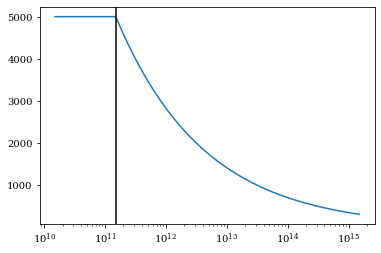

In [136]:
plt.plot(rs, get_temperature(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')

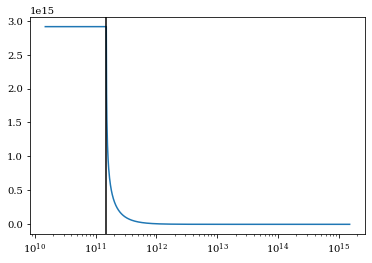

In [137]:
plt.plot(rs, get_abundance(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')

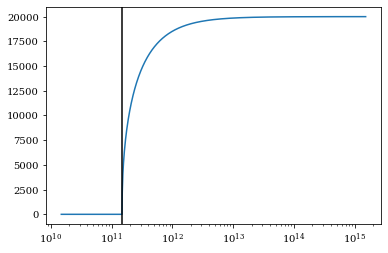

In [138]:
plt.plot(rs, get_velocity(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')
# plt.ylim((10000, 20000))

In [139]:
Is = smodel.image(lines, frequencies, r_max=r_max)

100%|██████████| 1023/1023 [00:04<00:00, 240.44it/s]


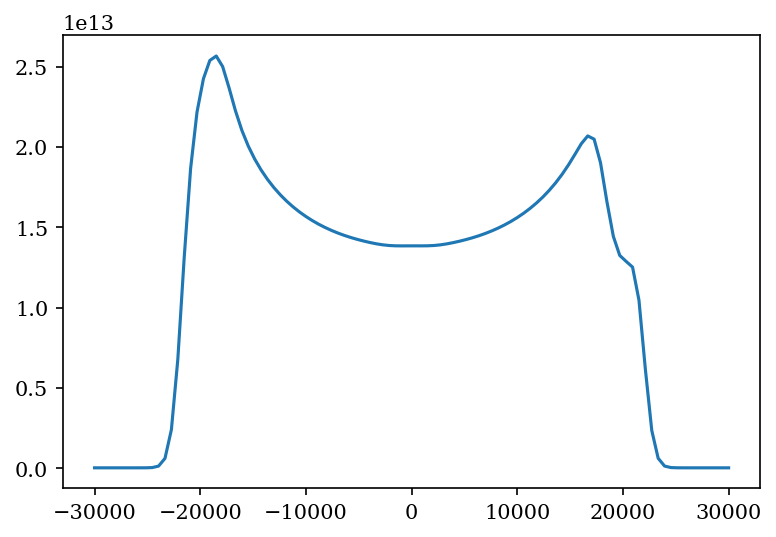

In [140]:
plt.figure(dpi=150)
for I in Is:
    plt.plot(velocities, I.data)

In [95]:
from tqdm import tqdm

# Extract the model parameters
velocity    = smodel.get_velocity   (smodel.model_1D)
abundance   = smodel.get_abundance  (smodel.model_1D)
temperature = smodel.get_temperature(smodel.model_1D)
turbulence  = smodel.get_turbulence (smodel.model_1D)

# Surface area of the annulus at each impact parameter
dss = np.pi * (smodel.rs[1:] + smodel.rs[:-1]) * (smodel.rs[1:] - smodel.rs[:-1])

line = lines[0]
freq = frequencies[0]

II = torch.zeros((smodel.Nb, len(freq)))
TT = torch.zeros((smodel.Nb, len(freq)))

for i in tqdm(range(smodel.Nb)):

    # Get boundary condition at this impact parameter
    img_bdy = smodel.get_boundary_condition(smodel.model_1D, frequency=freq, b=smodel.rs[i])

    # Get intensity at this impact parameter
    I_loc = line.LTE_image_along_last_axis(
        abundance    = abundance  [smodel.idss[i]],
        temperature  = temperature[smodel.idss[i]],
        v_turbulence = turbulence [smodel.idss[i]],
        velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i],
        frequencies  = freq,
        dx           = smodel.dZss[i],
        img_bdy      = img_bdy
    )

    II[i] = I_loc

    pop = line.LTE_pops(temperature = temperature[smodel.idss[i]])
    eta_ij_loc, chi_ij_loc = line.emissivity_and_opacity_ij(pop=pop)
    dtau_, tau_ = line.optical_depth_along_last_axis(
            chi_ij       = chi_ij_loc,
            abundance    = abundance  [smodel.idss[i]],
            temperature  = temperature[smodel.idss[i]],
            v_turbulence = turbulence [smodel.idss[i]],
            velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i],
            frequencies  = frequencies[0],
            dx           = smodel.dZss[i]
    )

    TT[i] = tau_[-1]


100%|██████████| 1023/1023 [00:10<00:00, 98.19it/s]


In [96]:
from ipywidgets import interact

In [16]:

def plot(i):

    fig, axs = plt.subplots(3,1, dpi=150)
    axs[0].plot(velocities, II[i]*dss[i])
    axs[1].plot(velocity[smodel.idss[i]] * smodel.diss[i])
    axs[2].plot(abundance[smodel.idss[i]])

interact(plot, i=(0,smodel.Nb-1))

interactive(children=(IntSlider(value=511, description='i', max=1022), Output()), _dom_classes=('widget-intera…

<function __main__.plot(i)>

In [17]:
def plot(i):
    fig, axs = plt.subplots(2,1, dpi=150)
    axs[0].plot(velocities, II[i])
    axs[1].plot(velocities, TT[i])
interact(plot, i=(0,smodel.Nb-1))

interactive(children=(IntSlider(value=511, description='i', max=1022), Output()), _dom_classes=('widget-intera…

<function __main__.plot(i)>

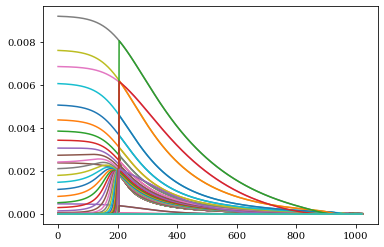

In [21]:
for f in range(TT.shape[1]):
    plt.plot(TT[:,f])

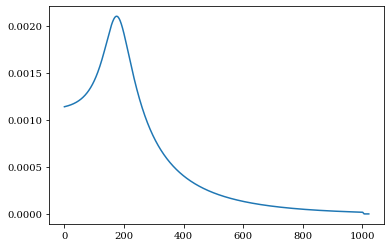

In [28]:
plt.plot(TT[:,30])

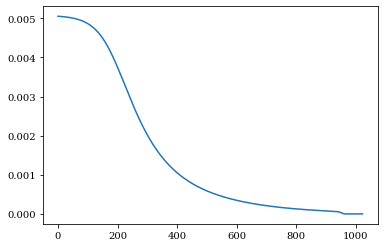

In [25]:
plt.plot(TT[:,20])

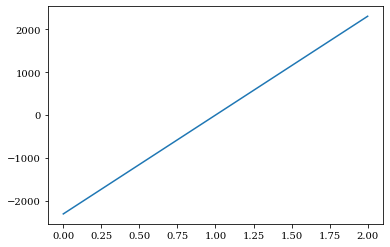

In [35]:
plt.plot(velocity[smodel.idss[i]] * smodel.diss[i])